In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import torch
import notebooks.attention as attention
import notebooks.audio_utils as audio

from datasets import load_from_disk

In [3]:
dataset = load_from_disk("./tedlium/validation.hf").with_format("torch").select(range(100))

In [5]:
model, processor = attention.init()

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
print(dataset[1], dataset[1]["audio"].shape[0] / 16000)

{'audio': tensor([ 0.0564,  0.0104, -0.0457,  ..., -0.0081, -0.0129, -0.0132]), 'text': 'i want to start out by asking you to think back to when you were a kid playing with blocks as you figured out how to reach out and grasp pick them up and move them around you were actually learning how to think and solve problems by understanding and manipulating spatial relationships'} 14.14


In [59]:
example = dataset[1]["audio"]

In [60]:
audio.play_audio(example)

In [61]:
res, _, e_attns, d_attns, c_attns = attention.inference(example, model, processor, skip_special_tokens=True)

In [13]:
filename = None

encoder_filename = None if not filename else filename + "_encoder.png"
encoder_truncated_filename = None if not filename else filename + "_encoder_truncated.png"
decoder_filename = None if not filename else filename + "_decoder.png"
cross_filename = None if not filename else filename + "_cross.png"
cross_truncated_filename = None if not filename else filename + "_cross_truncated.png"

# Encoder Attentions

In [11]:
list(map(lambda x: x.size(), e_attns))

[torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500]),
 torch.Size([1, 6, 1500, 1500])]

In [62]:
encoder_limit = int(example.size(0) / 16000 * 50) + 1
encoder_limit

708

In [ ]:
attention.plot_attns(torch.stack(e_attns), 8, 3, figsize=(30, 80), filename=encoder_filename)

In [ ]:
attention.plot_attns(torch.stack(e_attns).squeeze()[:, :, :encoder_limit, :encoder_limit], 8, 3, figsize=(30, 80), filename=encoder_truncated_filename)

# Decoder Attentions

In [ ]:
list(map(lambda x: tuple(map(lambda y: y.size(), x)), d_attns))

In [210]:
d_attns_stacked = [F.pad(torch.stack(d).squeeze(), (0, d_attns[-1][-1].size(3) - d[-1].size(3), 0, 0), "constant", 0.0) for d in d_attns[1:]]

In [214]:
d_attns_nett = torch.stack(d_attns_stacked).permute(1, 2, 0, 3)
d_attns_nett.shape

torch.Size([4, 6, 18, 20])

In [ ]:
attention.plot_attns(d_attns_nett, 6, 4, figsize=(40, 60), filename=decoder_filename)

# Cross Attentions

In [1]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit + 10]
attention.plot_attns(c_attns_stacked_cutoff, 8, 3, figsize=(30, 80), filename=cross_truncated_filename)

NameError: name 'torch' is not defined

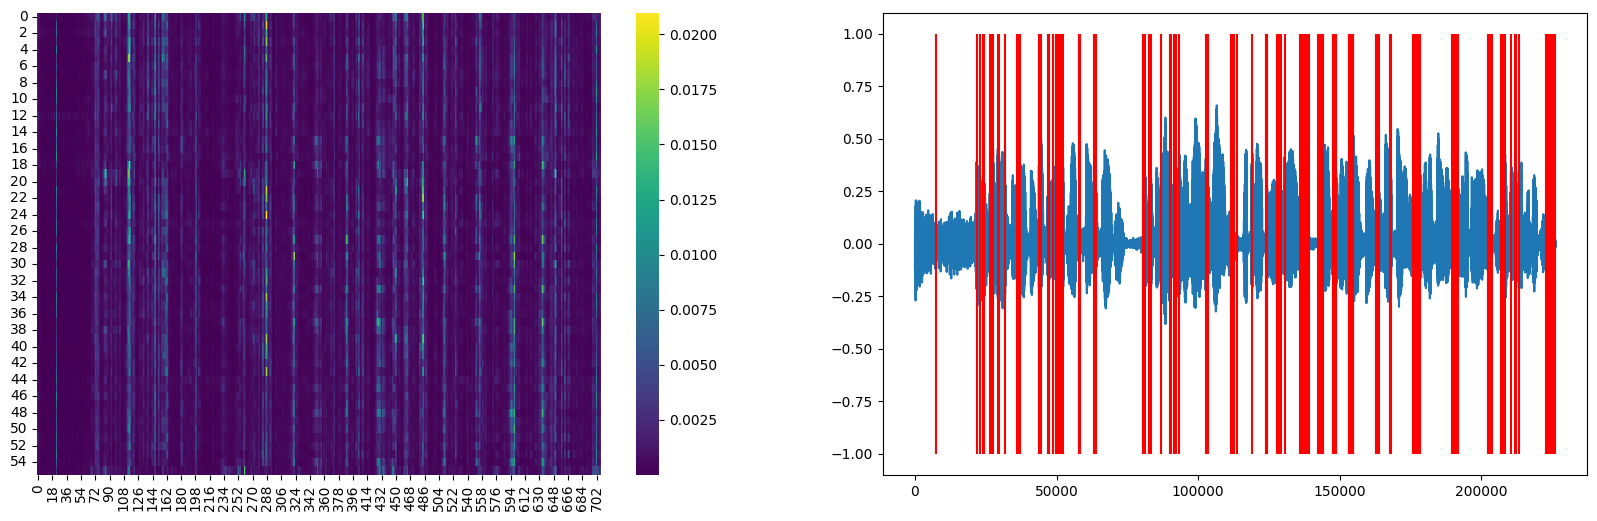

In [90]:
attention.plot_spikes(example, c_attns_stacked_cutoff[1, 4], 0.2)

In [59]:
audio.play_audio(example[start:])